In [ ]:
%cd ..
# Ensure that you are in the root directory of the repo

# Load file names

In [1]:
!pip install torchinfo

import pandas as pd
import numpy as np
from torch.nn import init

import os
import sys
from tqdm import tqdm

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

from IPython.display import Audio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import pandas as pd
import numpy as np
from torchinfo import summary
from train.MelTrainHelper import TrainHelper
from inference.Infer import infer

from Preprocessor import *
import Constants

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
Tess = "./data/TESS"

tess_directory_list = os.listdir(Tess)
# print(tess_directory_list)
file_emotion = []
file_path = []

preprocessor = DataPreprocessor()   
file_paths, labels = preprocessor.get_file_paths_and_labels(Tess)

EMOTION_ENCODING = {'neutral':0, 'happy':1, 'sad':2, 'angry':3, 'fear':4, 'disgust':5, 'ps':6}
encoded_labels = [EMOTION_ENCODING[label] for label in labels]
# dataframe for emotion of files
emotion_df = pd.DataFrame(labels, columns=['Emotions'])
print("ALL EMOTIONS:", set(labels))
# dataframe for path of files.
path_df = pd.DataFrame(file_paths, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
data = Tess_df
Tess_df.head()

ALL EMOTIONS: {'fear', 'neutral', 'angry', 'disgust', 'sad', 'happy', 'ps'}


,Emotions,Path
0,sad,./data/TESS/YAF_sad/YAF_wife_sad.wav
1,sad,./data/TESS/YAF_sad/YAF_hate_sad.wav
2,sad,./data/TESS/YAF_sad/YAF_phone_sad.wav
3,sad,./data/TESS/YAF_sad/YAF_week_sad.wav
4,sad,./data/TESS/YAF_sad/YAF_raid_sad.wav


# Data Preprocessing

In [ ]:
SAMPLE_RATE = Constants.CNN_SAMPLING_RATE
signals = preprocessor.extract_audio_signals(Tess_df['Path'])

In [ ]:
mel_spectograms = preprocessor.extract_mel_spectograms(signals)

In [ ]:
with open('mel_spec_all.npy', 'wb') as f:
    np.save(f, mel_spectograms)

In [3]:
with open('mel_spec_all.npy', 'rb') as f:
    mel_spectograms = np.load(f)

In [4]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = preprocessor.train_val_test_split(mel_spectograms, encoded_labels)

In [5]:
X_train = preprocessor.reshape_scale_data(X_train)
X_test = preprocessor.reshape_scale_data(X_test)
X_val = preprocessor.reshape_scale_data(X_val)

# Create the model

In [6]:
class CNN(nn.Module):
    def __init__(self,num_emotions):
        super().__init__()
        # conv block
        conv2d_1 = nn.Conv2d(in_channels=1, out_channels=16, stride=1, padding=1, kernel_size=3)
        conv2d_2 = nn.Conv2d(in_channels=16, out_channels=32, stride=1, padding=1, kernel_size=3)
        conv2d_3 = nn.Conv2d(in_channels=32, out_channels=64, stride=1, padding=1, kernel_size=3)
        conv2d_4 = nn.Conv2d(in_channels=64, out_channels=64, stride=1, padding=1, kernel_size=3)
        conv2d_5 = nn.Conv2d(in_channels=64, out_channels=64, stride=1, padding=1, kernel_size=3)
        
        relu = nn.ReLU()
        maxPool2_2 = nn.MaxPool2d(kernel_size=2, stride=2)
        maxPool4_4 = nn.MaxPool2d(kernel_size=4, stride=4)
        dropOut = nn.Dropout(p=0.3)
        batchNorm16 = nn.BatchNorm2d(16)
        batchNorm32 = nn.BatchNorm2d(32)
        batchNorm64 = nn.BatchNorm2d(64)

        self.conv2Dblock = nn.Sequential(conv2d_1, batchNorm16, relu, maxPool2_2, dropOut,
                                         conv2d_2, batchNorm32, relu, maxPool4_4, dropOut,
                                         conv2d_3, batchNorm64, relu, maxPool4_4, dropOut,
                                         conv2d_4, batchNorm64, relu, maxPool4_4, dropOut)

        self.first_linear = nn.Linear(256,256)
        self.relu = nn.ReLU()
        self.out_linear = nn.Linear(256,num_emotions)
        self.dropout_linear = nn.Dropout(p=0.3)
        self.out_softmax = nn.Softmax(dim=1)
    
    def forward(self,x):
        out_conv = self.conv2Dblock(x) 
        out_conv = torch.flatten(out_conv, start_dim=1)

        first_linear = self.first_linear(out_conv) 
        relu = self.relu(first_linear)
        output_logits = self.out_linear(first_linear)
        output_logits = self.dropout_linear(output_logits)
        output_softmax = self.out_softmax(output_logits)
        return output_logits, output_softmax

# Visualizing Mel Spectrograms

In [29]:
audio = preprocessor.extract_audio_signals(["./data/TESS/YAF_happy/YAF_wife_happy.wav"])
Audio(audio,rate=48000)


 extract_audio_signals: Processed 0/1 files

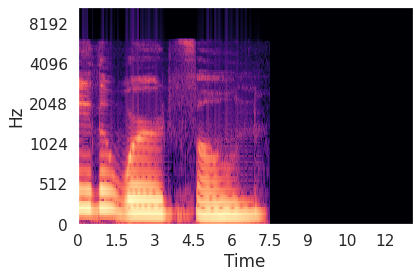

In [30]:
librosa.display.specshow(mel_spectograms[2].squeeze(), y_axis='mel', x_axis='time',cmap='magma')
Audio(audio,rate=48000)

# TRAINING

In [8]:
train_helper = TrainHelper()
model = CNN(num_emotions=7).to('cuda')
model, losses, train_accuracies, val_losses, val_accuracies = train_helper.model_train(model, 50, 32, X_train, Y_train, X_val, Y_val, 'cuda', 0.0001, optimizer="Adam")

Number of trainable params:  128039
 Epoch 0: iteration 69/70
Epoch 0 --> loss:1.8979, acc:23.12%, val_loss:1.9110, val_acc:31.79%
 Epoch 1: iteration 69/70
Epoch 1 --> loss:1.8647, acc:28.93%, val_loss:1.8879, val_acc:36.07%
 Epoch 2: iteration 69/70
Epoch 2 --> loss:1.8225, acc:34.20%, val_loss:1.8587, val_acc:42.14%
 Epoch 3: iteration 69/70
Epoch 3 --> loss:1.7769, acc:41.16%, val_loss:1.8418, val_acc:52.50%
 Epoch 4: iteration 69/70
Epoch 4 --> loss:1.7578, acc:41.07%, val_loss:1.8226, val_acc:58.57%
 Epoch 5: iteration 69/70
Epoch 5 --> loss:1.7306, acc:45.27%, val_loss:1.7840, val_acc:60.00%
 Epoch 6: iteration 69/70
Epoch 6 --> loss:1.7258, acc:43.84%, val_loss:1.7785, val_acc:61.79%
 Epoch 7: iteration 69/70
Epoch 7 --> loss:1.6951, acc:47.50%, val_loss:1.7632, val_acc:57.86%
 Epoch 8: iteration 69/70
Epoch 8 --> loss:1.6909, acc:47.68%, val_loss:1.7562, val_acc:60.36%
 Epoch 9: iteration 69/70
Epoch 9 --> loss:1.6802, acc:49.33%, val_loss:1.7504, val_acc:61.07%
 Epoch 10: ite

# Save model

In [9]:
SAVE_PATH = os.path.join(os.getcwd(),'models')
os.makedirs('models',exist_ok=True)
torch.save(model.state_dict(),os.path.join(SAVE_PATH,'cnn_8235723985738957OG.pt'))
print('Model is saved to {}'.format(os.path.join(SAVE_PATH,'cnn_8235723985738957OG.pt')))

Model is saved to /home/jovyan/50.039-Deep-Learning-Project-Tonality-Recognition/models/cnn_8235723985738957OG.pt


# Load model

In [10]:
LOAD_PATH = os.path.join(os.getcwd(),'models')
model = CNN(7)
model.load_state_dict(torch.load(os.path.join(LOAD_PATH,'cnn_8235723985738957OG.pt')))
print('Model is loaded from {}'.format(os.path.join(LOAD_PATH,'cnn_8235723985738957OG.pt')))

Model is loaded from /home/jovyan/50.039-Deep-Learning-Project-Tonality-Recognition/models/cnn_8235723985738957OG.pt


# Test

In [11]:
train_helper = TrainHelper()
device = 'cuda' # If you are loading model from weights, please use cpu
print('Selected device is {}'.format(device))
X_test_tensor = torch.tensor(X_test,device=device).float()
Y_test_tensor = torch.tensor(Y_test,dtype=torch.long,device=device)

test_loss, test_acc, predictions = train_helper.validate(X_test_tensor,Y_test_tensor,model)
print(f'Test loss is {test_loss:.3f}')
print(f'Test accuracy is {test_acc:.2f}%')

Selected device is cpu
Test loss is 1.332
Test accuracy is 92.86%


## Confusion Matrix


{'neutral': 0, 'happy': 1, 'sad': 2, 'angry': 3, 'fear': 4, 'disgust': 5, 'ps': 6}


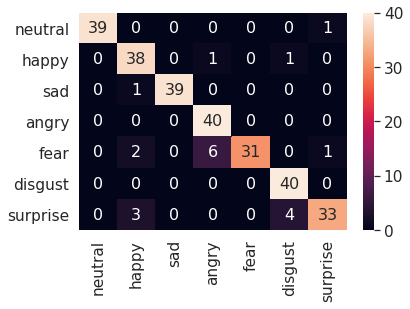

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
EMOTIONS = {0:'neutral',1:'happy',2:"sad",3: 'angry',4:"fear",5:"disgust",6:"surprise"}
print(EMOTION_ENCODING)
predictions = predictions.cpu().numpy() # If device is cuda, please remove comment this line
cm = confusion_matrix(Y_test, predictions)
names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
df_cm = pd.DataFrame(cm, index=names, columns=names)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

# Plot loss

In [27]:
def generate_plot(train, val, filename, typ='loss', model='MLP', savepath='figs/'):
    if len(train) != len(val):
        raise Exception("Input data arrays of different length.")
    
    # params
    nepochs = len(train)
    title_fontsize = '18'
    label_fontsize = '15'
    xtick_fontsize = '14'
    ytick_fontsize = '14'
    
    fig = plt.figure(figsize=(8,6))
    x = np.arange(nepochs)
    
    plt.plot(x, train, label='train')
    plt.plot(x, val, label='val')
    title = ''
    if typ == 'loss':
        title = 'Training and Validation Loss'
        ylabel = 'Loss Value'
    elif typ == 'acc':
        title = 'Training and Validation Accuracy'
        ylabel = 'Accuracy'
        
    title = title + ' ' + '(' + model + ')'
        
    xlabel = 'Epochs'
    plt.title(title, fontsize=title_fontsize)
    plt.xlabel(xlabel, fontsize=label_fontsize)
    plt.ylabel(ylabel, fontsize=label_fontsize)
    plt.xticks(fontsize=xtick_fontsize)
    plt.yticks(fontsize=ytick_fontsize)
    plt.legend(fontsize=ytick_fontsize, bbox_to_anchor=(1.04,1), loc="upper left")
    plt.tight_layout()
#     plt.savefig('./Figs/' + filename + '.png', dpi=250)
    plt.show()

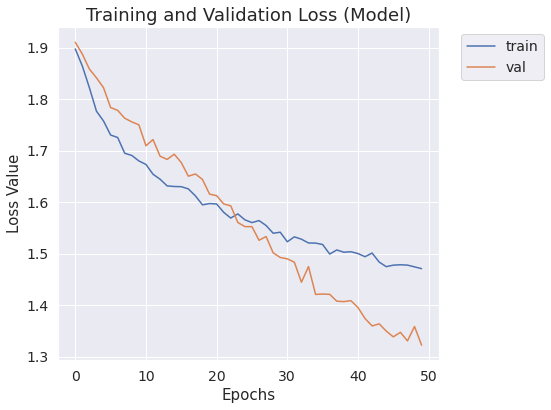

In [28]:
generate_plot(losses,val_losses,"File",'loss',"Model",'figs/')

# Inferring single or multiple samples

In [16]:
#Inferring Single Sample
single_test = "./data/TESS/YAF_sad/YAF_wife_sad.wav"
infer(model,[single_test],mel_spectograms, device='cpu') # Please match the device type correctly
audio = preprocessor.extract_audio_signals([single_test])
Audio(audio,rate=48000)

Audio File:  ./data/TESS/YAF_sad/YAF_wife_sad.wav
Predicted Emotions:  sad 	| Ground Truth:  sad
Top 1:  sad Prob:  97.672 % 	| Top 2:  angry Prob:  1.065 % 	| Top 3:  happy Prob:  0.473 %

 extract_audio_signals: Processed 0/1 files

In [18]:
#Inferring a list of Samples
file_ls = ["./data/TESS/YAF_sad/YAF_wife_sad.wav","./data/TESS/YAF_fear/YAF_wife_fear.wav","./data/TESS/YAF_happy/YAF_wife_happy.wav","./data/TESS/YAF_neutral/YAF_wife_neutral.wav"]
infer(model, file_ls ,mel_spectograms, device='cpu') # Please match the device type correctly

 extract_mel_spectograms: Processed 3/4 files

Audio File:  ./data/TESS/YAF_sad/YAF_wife_sad.wav
Predicted Emotions:  sad 	| Ground Truth:  sad
Top 1: sad (Prob: 97.67 %) 	| Top 2: angry (Prob: 1.06 %) 	| Top 3: happy (Prob: 0.47 %)

Audio File:  ./data/TESS/YAF_fear/YAF_wife_fear.wav
Predicted Emotions:  fear 	| Ground Truth:  fear
Top 1: fear (Prob: 98.27 %) 	| Top 2: happy (Prob: 1.34 %) 	| Top 3: angry (Prob: 0.2 %)

Audio File:  ./data/TESS/YAF_happy/YAF_wife_happy.wav
Predicted Emotions:  happy 	| Ground Truth:  happy
Top 1: happy (Prob: 92.39 %) 	| Top 2: disgust (Prob: 3.45 %) 	| Top 3: angry (Prob: 3.25 %)

Audio File:  ./data/TESS/YAF_neutral/YAF_wife_neutral.wav
Predicted Emotions:  neutral 	| Ground Truth:  neutral
Top 1: neutral (Prob: 94.63 %) 	| Top 2: happy (Prob: 1.81 %) 	| Top 3: ps (Prob: 1.09 %)

